In [1]:
import sys
sys.path.append("..")

import logging 
logging.basicConfig(level=logging.INFO)

import os
import ast
import smart_open

import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from tqdm import tqdm
from datetime import datetime
from collections import OrderedDict

from scripts.src.data_reading import *

C:\Users\harshasivajit\AppData\Local\Continuum\miniconda3\envs\venv\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [5]:
def create_df():
    
    root = "rcv1.tar/rcv1/"

    files = []

    for (dirpath, dirnames, filenames) in os.walk(root):
        for name in filenames:
            path = "{}/{}".format(dirpath, name)
            files.append(path)

    item_id = []
    cat_list = []
    date_list = []
    raw_text = []

    for file in tqdm(files[1:-8]):
        tree = ET.parse(file)
        d = {}
        d['text'] = ''

        for child in tree.getiterator():            
            for k, v in child.attrib.items():
                if k not in d:
                    d[k] = [v]
                else:
                    d[k].append(v)
            try:
                if len(child.text.strip()) > 1:
                    d['text'] += child.text
            except:
                pass


        item_id.append(int(d['itemid'][0]))
        date_list.append(d['date'][0])
        cat_list.append(d['code'])
        raw_text.append(d['text'])

    rcv1_text_df = pd.DataFrame(columns = ["doc_id", "text", "date", "categories"])
    rcv1_text_df["doc_id"] = item_id
    rcv1_text_df["text"] = raw_text
    rcv1_text_df["date"] = date_list
    rcv1_text_df["categories"] = cat_list

    save_dest = "rcv1.tar/raw_text_df.tsv"

    rcv1_text_df.to_csv(save_dest, sep='\t', index=False)
    
    return save_dest

# df_file = create_df()

# raw_df = pd.read_csv("rcv1.tar/raw_text_df.tsv", sep="\t", index_col=0) #df_file

In [ ]:
# getting list of topic codes
def get_codes(filename):
    topics = []
    with smart_open.smart_open(filename, "r") as t:
        for line in t:
            el = line.strip().split("\t")
            topics.append(el[0])
    
    topic_codes = topics[2:-1]
    return topic_codes

def func(listxlist, major_list):
    res = []
    for ids in listxlist:
        if ids in major_list:
            res.append(ids)
    
    if len(res) == 0:
        res = np.nan
    return res

def generate_cat_hier(filename):
    new = []
    with smart_open.smart_open(filename, "r") as file:
        for line in file:
            el = line.strip().split("parent:")
            parent = el[1].strip().split("child:")
            p = parent[0].strip().split(" ")[0]
            child = parent[1].strip().split(" ")[0]
            if p != "Root" :
                new.append((p, child))
    return new[1:]

def cat_of_n(n):
    sadlist = set()
    ordrd = OrderedDict()

    for p, c in n:
        if p not in sadlist:
            sadlist.add(p)
        if c not in sadlist:
            sadlist.add(c)

    for i, j in enumerate(sadlist):
        ordrd[j] = i

    rev_or = {v:k for k, v in ordrd.items()}
    
    return ordrd, rev_or


In [ ]:
def process_raw_df(raw_df):
    
    raw_df["categories"] = raw_df["categories"].apply(lambda x: ast.literal_eval(x))

    n = generate_cat_hier("rcv1.tar/rcv1.topics.hier.orig.txt")

    topic_codes = get_codes("rcv1.tar/rcv1/codes/topic_codes.txt")
    region_codes = get_codes("rcv1.tar/rcv1/codes/region_codes.txt")

    orig, rev = cat_of_n(n)

    cat_file = "rcv1.tar/rcv1_topics_cat_hier.txt"
    file = open(cat_file, "w+")
    for p, c in n:
        string = "{} {}\n".format(orig[p], orig[c])
        file.write(string)
    file.close()

    raw_df["topic_categories"] = ''
    raw_df["region_categories"] = ''
    raw_df["split"] = ''

    raw_df["topic_categories"] = raw_df["categories"].apply(lambda x: func(x, topic_codes))
    raw_df["region_categories"] = raw_df["categories"].apply(lambda x: func(x, region_codes))
    raw_df["date"] = pd.to_datetime(raw_df["date"])

    train_in = pd.Timestamp(year=1996, month=8, day=20)
    train_out = pd.Timestamp(year=1996, month=8, day=31)

    for ix in tqdm(raw_df.index):
        if raw_df.at[ix, "date"] >= train_in and raw_df.at[ix, "date"] <= train_out:
            raw_df.at[ix, "split"] = 'training'
        else:
            raw_df.at[ix, "split"] = 'testing'

    raw_df = raw_df.dropna()

    raw_df = raw_df.drop(columns="Unnamed: 0")

    # convert topic list to topic id list
    raw_df["topic_ids"] = raw_df["topic_categories"].apply(lambda x: [orig[item] for item in x])

    raw_df.to_csv("rcv1.tar/rcv1_ckpt.tsv", sep='\t', index=False)
    
    return raw_df_df

In [3]:
raw_df = pd.read_csv("../rcv1.tar/rcv1_ckpt.tsv", sep='\t', index_col=0)

In [19]:
raw_df.head(4)

,doc_id,text,date,categories,topic_categories,region_categories,split,topic_ids
0,2286,MEXICO: Recovery excitement brings Mexican mar...,1996-08-20,"['MEX', 'E11', 'ECAT', 'M11', 'M12', 'MCAT']","['E11', 'ECAT', 'M11', 'M12', 'MCAT']",['MEX'],training,"[101, 32, 1, 18, 37]"
1,2287,USA: Chrysler plans new investments in Latin A...,1996-08-20,"['ARG', 'BRAZ', 'USA', 'I24700', 'I34320', 'I3...","['C24', 'CCAT']","['ARG', 'BRAZ', 'USA']",training,"[82, 33]"
2,2288,"USA: CompuServe reports loss, cutting work for...",1996-08-20,"['USA', 'I83940', 'C15', 'C151', 'CCAT', 'E41'...","['C15', 'C151', 'CCAT', 'E41', 'ECAT', 'GCAT',...",['USA'],training,"[41, 23, 33, 28, 32, 15, 5]"
3,2289,"USA: CompuServe reports loss, cutting work for...",1996-08-20,"['USA', 'I83940', 'C15', 'C151', 'CCAT']","['C15', 'C151', 'CCAT']",['USA'],training,"[41, 23, 33]"


In [9]:
class FTextIter(object):
    def __init__(self, file_path):
        super(FTextIter, self).__init__()
        self.file_path = file_path

    def __iter__(self):
        with smart_open.smart_open(self.file_path, 'r') as fin:
            for line in fin:
                line = preprocess_string(line)
                yield list(line)

In [10]:
def get_text(prefix, df):

    fname = "{}/all_rcv1_raw.txt".format(prefix)
    fe, ex = os.path.splitext(fname)
    
    if not os.path.isfile(fname):
        file = open(fname, "w+", newline='\n')

        for i in tqdm(df.index):
            str_each_line = df.at[i, "text"]
            file.write(str_each_line)

        file.close()

    return fe

In [11]:
def fasttext_generator(fname):
    '''
    prefix: path to save the file
    '''
    fe, ex = os.path.splitext(fname)
    filename = "{}.model".format(fe)

    if not os.path.isfile(filename):
        moo = FastText(size=300, window=3, min_count=1) # hs=0, negative=0, size=300
        moo.build_vocab(sentences=FTextIter(fname))
        total_examples = moo.corpus_count
        moo.train(sentences=FTextIter(fname), total_examples=total_examples, epochs=5)
        moo.save(filename)
    else:
        moo = FastText.load(filename)

    return moo

In [20]:
def gen_doc2vec(df, prefix):
    '''
    prefix: os file path to pickle file/saved models
    '''
    save_dest = "{}/rcv1_fasttextV1.tsv".format(prefix)

    if not os.path.isfile(save_dest):
        logging.info("Generating document vectors...")
        fname = get_text(prefix, df)
        feex = fname + ".txt"
        model = fasttext_generator(feex)
        
        temp_col = []
        for index in tqdm(df.index):
            vec = []
            line = preprocess_string(raw_df.at[index, "text"])
            for word in line:
                vec.append(model.wv[word])
            temp_col.append(np.mean(vec, axis=0))

        df["vec"] = temp_col
        
        result = df.sort_index(0)
        
        result.to_csv(save_dest, sep='\t', index=False)

    else:
        logging.info("Loading exisiting model... ")
        result = pd.read_csv(save_dest, sep='\t', index_col=0)

    return result

In [21]:
res = gen_doc2vec(raw_df, "rcv1.tar") #run this only once

INFO:root:Loading exisiting model... 


In [22]:
grouped = res.groupby("split")
tr = grouped.get_group("training")
te = grouped.get_group("testing")

In [23]:
tr = tr.drop(columns=["categories", "region_categories"])

In [24]:
te = te.drop(columns=["categories", "region_categories"])

In [27]:
tr.shape, te.shape

((23149, 7), (781265, 7))

In [28]:
tr.to_csv("rcv1.tar/rcv1_fasttext_train.tsv", sep='\t', index=False)
te.to_csv("rcv1.tar/rcv1_fasttext_test.tsv", sep='\t', index=False)

In [9]:
tr = pd.read_csv("../rcv1.tar/rcv1_fasttext_train.tsv", sep="\t", index_col=0)

In [10]:
tr = tr.rename(columns={'topic_categories': 'doc_labels'})

In [25]:
tr["doc_labels"] = tr["doc_labels"].apply(lambda x: ast.literal_eval(x))

100%|████████████████████████████████████████████████████████████████████████| 23149/23149 [00:00<00:00, 149171.74it/s]


0

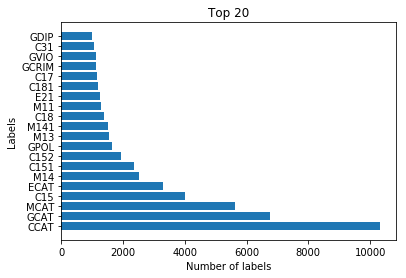

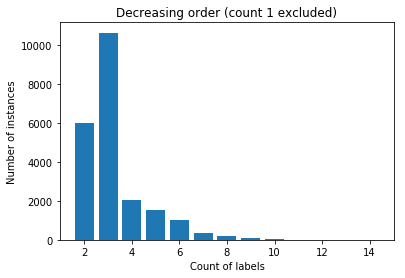

In [28]:
class_statistics(tr, "rcv1")